# Homework #2

과목: 딥러닝및실습  
분반: 01분반  
학번: 2021136128  
이름: 조은샘

## [요구사항 1] titanic_dataset.py 분석

In [1]:
import os
import pandas as pd
import torch 
from torch.utils.data import Dataset, DataLoader, random_split 

os모듈: 파일 및 디렉토리와 같은 운영 체제 기능  
pandas 모듈: 데이터 분석 기능  
torch 모듈: 딥러닝 관련 기능  
Dataset, DataLoader, random_split 클래스: PyTorch의 데이터 처리 기능

In [2]:
# 데이터셋 클래스
class TitanicDataset(Dataset):
  def __init__(self, X, y):
    self.X = torch.FloatTensor(X) # input (feature)
    self.y = torch.LongTensor(y) # target

  def __len__(self):
    return len(self.X) # input 크기

  def __getitem__(self, idx):
    feature = self.X[idx]
    target = self.y[idx]
    return {'input': feature, 'target': target} # input, target 값

  def __str__(self):
    str = "Data Size: {0}, Input Shape: {1}, Target Shape: {2}".format(
      len(self.X), self.X.shape, self.y.shape
    )
    return str # 크기, 형태 문자열

In [3]:
# 테스트 데이터셋 클래스 (데이터셋과 달리 target에 관한 정보 포함 안함)
class TitanicTestDataset(Dataset):
  def __init__(self, X):
    self.X = torch.FloatTensor(X) # input (feature)

  def __len__(self):
    return len(self.X) # input 크기

  def __getitem__(self, idx):
    feature = self.X[idx]
    return {'input': feature} # input 값

  def __str__(self):
    str = "Data Size: {0}, Input Shape: {1}".format(
      len(self.X), self.X.shape
    )
    return str # 크기, 형태 문자열

In [4]:
# 전처리된 데이터셋 얻는 함수
def get_preprocessed_dataset():

    # - 경로 얻기
    CURRENT_FILE_PATH = os.path.dirname(os.path.abspath("__file__")) # 현재 파일 경로

    train_data_path = os.path.join(CURRENT_FILE_PATH, "train.csv") # 데이터 파일 경로
    test_data_path = os.path.join(CURRENT_FILE_PATH, "test.csv")

    # - 파일 읽기 및 데이터 프레임 만들기
    train_df = pd.read_csv(train_data_path) # 학습
    test_df = pd.read_csv(test_data_path) # 테스트

    # - 데이터 합쳐 전체 데이터 프레임 만들기
    all_df = pd.concat([train_df, test_df], sort=False) # 합칠 때 정렬하지 않는 옵션 부여

    # - 여러 전처리 진행 (함수 호출)
    # Pclass별 Fare 평균값을 사용하여 Fare 결측치 메우기
    all_df = get_preprocessed_dataset_1(all_df)

    # name을 세 개의 컬럼으로 분리하여 다시 all_df에 합침
    all_df = get_preprocessed_dataset_2(all_df)

    # honorific별 Age 평균값을 사용하여 Age 결측치 메우기
    all_df = get_preprocessed_dataset_3(all_df)

    # 가족수(family_num) 컬럼 새롭게 추가
    all_df = get_preprocessed_dataset_4(all_df)

    # honorific 값 개수 줄이기
    all_df = get_preprocessed_dataset_5(all_df)

    # 카테고리 변수를 LabelEncoder를 사용하여 수치값으로 변경하기
    all_df = get_preprocessed_dataset_6(all_df)

    # - 데이터 선택
    # 전체 데이터 프레임에서 Survived가 결측치가 아닌 데이터를 선택하고, Survived 컬럼 제거 및 인덱스 초기화 
    # (컬럼 제거 이유는 레이블 컬럼이기 때문에 학습에 사용하지 않기 때문)
    train_X = all_df[~all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)
    
    # 학습 데이터 프레임에서 Survived 컬럼 선택
    train_y = train_df["Survived"]
    
    # 전체 데이터 프레임에서 Survived가 결측치인 데이터를 선택하고, Survived 컬럼 제거 및 인덱스 초기화 
    test_X = all_df[all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)

    # - 데이터셋 생성
    # 데이터셋 생성 (TitanicDataset클래스를 이용)
    dataset = TitanicDataset(train_X.values, train_y.values)
    #print(dataset)

    # 데이터셋을 80%와 20%로 분할 (학습 데이터셋과 검증 데이터셋)
    train_dataset, validation_dataset = random_split(dataset, [0.8, 0.2])

    # 테스트 데이터셋 생성 (TitanicTestDataset 클래스 이용)
    test_dataset = TitanicTestDataset(test_X.values)
    #print(test_dataset)

    # - 학습, 검증, 테스트 데이터셋 반환
    return train_dataset, validation_dataset, test_dataset

In [5]:
def get_preprocessed_dataset_1(all_df):
    # Pclass별 Fare 평균값을 사용하여 Fare 결측치 메우기
    
    # all_df에서 Pclass와 Fare 컬럼을 추출하여 Pclass 기준으로 그룹화, 그룹별 평균값 계산, 인덱스 초기화
    # 데이터 프레임의 컬럼 이름 지정
    Fare_mean = all_df[["Pclass", "Fare"]].groupby("Pclass").mean().reset_index()
    Fare_mean.columns = ["Pclass", "Fare_mean"]

    # 두 데이터 프레임을 Pclass 컬럼을 기준으로 병합, all_df에 결측치가 있는 경우 Fare_mean에서 해당 값 가져옴
    # all_df에서 Fare 결측치가 있는 행의 Fare 값을 Fare_mean 값으로 대체
    all_df = pd.merge(all_df, Fare_mean, on="Pclass", how="left")
    all_df.loc[(all_df["Fare"].isnull()), "Fare"] = all_df["Fare_mean"]

    # Fare 결측치가 메워진 전체 데이터 프레임 반환
    return all_df

In [6]:
def get_preprocessed_dataset_2(all_df):
    # name을 세 개의 컬럼으로 분리하여 다시 all_df에 합침

    # all_df에서 Name 컬럼을 ',' 또는 '.'을 기준으로 분리하고, 분리된 컬럼을 모두 반환하여 이름 데이터 프레임 생성
    name_df = all_df["Name"].str.split("[,.]", n=2, expand=True)

    # 컬럼 이름 지정
    # family_name: 성 / honorific: 경칭 / name: 이름
    name_df.columns = ["family_name", "honorific", "name"]

    # 컬럼의 공백 제거
    name_df["family_name"] = name_df["family_name"].str.strip()
    name_df["honorific"] = name_df["honorific"].str.strip()
    name_df["name"] = name_df["name"].str.strip()

    # all_df에 name_df 병합, 열 방향으로
    all_df = pd.concat([all_df, name_df], axis=1)

    # 이름 컬럼 3개가 추가된 전체 데이터 프레임 반환
    return all_df

In [7]:
def get_preprocessed_dataset_3(all_df):
    # honorific별 Age 평균값을 사용하여 Age 결측치 메우기

    # all_df에서 honorific, Age 컬럼을 추출하여 honorific 기준으로 그룹화, Age의 중앙값 계산, 소수점 이하 반올림, 이인덱스 초기화
    # 데이터 프레임의 컬럼 이름 지정
    honorific_age_mean = all_df[["honorific", "Age"]].groupby("honorific").median().round().reset_index()
    honorific_age_mean.columns = ["honorific", "honorific_age_mean", ]

    # 두 데이터 프레임을 honorific 컬럼을 기준으로 병합, all_df에 결측치가 있는 경우 honorific_age_mean에서 해당 값 가져옴
    # all_df에서 Age 결측치가 있는 행의 Age값을 honorific_age_mean 값으로 대체
    all_df = pd.merge(all_df, honorific_age_mean, on="honorific", how="left")
    all_df.loc[(all_df["Age"].isnull()), "Age"] = all_df["honorific_age_mean"]

    # all_df에서 honorific_age_mean 컬럼을 제거
    all_df = all_df.drop(["honorific_age_mean"], axis=1)

    # Age 결측치가 메워진 전체 데이터 프레임 반환
    return all_df

In [8]:
def get_preprocessed_dataset_4(all_df):
    # 가족수(family_num) 컬럼 새롭게 추가

    # Parch와 SibSp 컬럼을 더하여 family_num 계산하여 할당
    all_df["family_num"] = all_df["Parch"] + all_df["SibSp"]

    # 혼자탑승(alone) 컬럼 새롭게 추가
    # 가족수가 0인 경우 혼자 탑승한 것으로 간주하여 1부여, 결측치가 있는 경우 0부여
    all_df.loc[all_df["family_num"] == 0, "alone"] = 1
    all_df["alone"].fillna(0, inplace=True)

    # 학습에 불필요한 컬럼 제거
    all_df = all_df.drop(["PassengerId", "Name", "family_name", "name", "Ticket", "Cabin"], axis=1)

    # family_num 컬럼 추가한 전체 데이터 프레임 반환
    return all_df

In [9]:
def get_preprocessed_dataset_5(all_df):
    # honorific 값 개수 줄이기

     # honorific 값이 Mr, Miss, Mrs, Master가 아닌 경우 other로 대체
    all_df.loc[
    ~(
            (all_df["honorific"] == "Mr") |
            (all_df["honorific"] == "Miss") |
            (all_df["honorific"] == "Mrs") |
            (all_df["honorific"] == "Master")
    ),
    "honorific"
    ] = "other"

    # Embarked 컬럼의 결측치를 missing으로 채우기
    all_df["Embarked"].fillna("missing", inplace=True)

    # 처리된 전체 데이터 프레임 반환
    return all_df

In [10]:
def get_preprocessed_dataset_6(all_df):
    # 카테고리 변수를 LabelEncoder를 사용하여 수치값으로 변경하기

    # all_df에서 object 타입의 컬럼을 추출
    category_features = all_df.columns[all_df.dtypes == "object"]

    # 카테고리 변수를 수치값으로 변환하기 위해 LabelEncoder 클래스 import
    from sklearn.preprocessing import LabelEncoder

    # category_features에 있는 컬럼을 순회
    for category_feature in category_features:
        # LabelEncoder 객체를 생성
        le = LabelEncoder()

        # 해당 컬럼의 데이터가 object인 경우
        if all_df[category_feature].dtypes == "object":
            # fit과 transfrom으로 레이블 인코딩 수행
            le = le.fit(all_df[category_feature])
            all_df[category_feature] = le.transform(all_df[category_feature])

    # 처리된 전체 데이터 프레임 반환 
    return all_df

In [11]:
# 신경망 모델을 개발하고, 학습하고, 평가하기 위해 PyTorch의 nn 모듈 import
from torch import nn

class MyModel(nn.Module):
  def __init__(self, n_input, n_output):
    super().__init__()

    # nn.Sequential 이용하여 신경망 생성
    # nn.Linear(입력 노드 수, 출력 노드 수) -> 레이어 생성
    # nnReLU() -> ReLU 활성화 함수 생성 (입력 데이터가 0보다 크면 그대로 출력, 작으면 0출력)
    self.model = nn.Sequential(
      nn.Linear(n_input, 30),
      nn.ReLU(),
      nn.Linear(30, 30),
      nn.ReLU(),
      nn.Linear(30, n_output),
    )

  def forward(self, x):
    # 입력 데이터를 모델에 입력하여 출력 값 저장 및 반환
    x = self.model(x)
    return x

In [13]:
def test(test_data_loader):
  print("[TEST]")

  # 테스트 데이터로부터 하나의 배치를 가져오기
  batch = next(iter(test_data_loader))

  # 한 배치의 input 데이터의 형태 출력
  print("{0}".format(batch['input'].shape))

  # 모델 생성
  my_model = MyModel(n_input=11, n_output=2)

  # 모델에 입력 데이터를 전달하고 출력 데이터 받기 (forward 함수 호출)
  output_batch = my_model(batch['input'])

  # 출력 데이터에서 가장 큰 값의 인덱스를 계산하여 예측 결과 받기
  prediction_batch = torch.argmax(output_batch, dim=1)

  # 예측 결과의 인덱스와 요소 출력 (idx는 892부터 시작)
  for idx, prediction in enumerate(prediction_batch, start=892):
      print(idx, prediction.item())

In [14]:
if __name__ == "__main__":
  # 전처리된 여러 데이터셋 얻기 (학습, 검증, 테스트)
  train_dataset, validation_dataset, test_dataset = get_preprocessed_dataset()

  # 데이터셋의 각 크기 출력
  print("train_dataset: {0}, validation_dataset.shape: {1}, test_dataset: {2}".format(
    len(train_dataset), len(validation_dataset), len(test_dataset)
  ))
  print("#" * 50, 1)

  # 학습 데이터셋을 순회하며 인덱스와 샘플의 input, tartget 데이터 출력
  for idx, sample in enumerate(train_dataset):
    print("{0} - {1}: {2}".format(idx, sample['input'], sample['target']))

  print("#" * 50, 2)

  # 학습, 검증, 테스트 데이터 로더 생성 (데이터셋을 일정한 크기의 배치로 나눔)
  # 배치 크기와 데디터셋을 섞을지 여부를 지정
  train_data_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
  validation_data_loader = DataLoader(dataset=validation_dataset, batch_size=16, shuffle=True)
  test_data_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset))

  print("[TRAIN]")
  # 학습 데이터 로더를 순회하며 인덱스와 배치의 input, target 데이터의 형태 출력
  for idx, batch in enumerate(train_data_loader):
    print("{0} - {1}: {2}".format(idx, batch['input'].shape, batch['target'].shape))

  print("[VALIDATION]")
  # 검증 데이터 로더를 순회하며 인덱스와 배치의 input, target 데이터의 형태 출력
  for idx, batch in enumerate(validation_data_loader):
    print("{0} - {1}: {2}".format(idx, batch['input'].shape, batch['target'].shape))

  print("#" * 50, 3)

  # 테스트 데이터로더를 사용하여 모델의 성능을 평가
  test(test_data_loader)


train_dataset: 713, validation_dataset.shape: 178, test_dataset: 418
################################################## 1
0 - tensor([ 3.0000,  1.0000,  1.0000,  1.0000,  2.0000, 20.5750,  2.0000, 13.3029,
         0.0000,  3.0000,  0.0000]): 1
1 - tensor([ 2.0000,  0.0000, 50.0000,  0.0000,  0.0000, 10.5000,  2.0000, 21.1792,
         1.0000,  0.0000,  1.0000]): 1
2 - tensor([ 3.0000,  1.0000, 30.0000,  1.0000,  0.0000, 16.1000,  2.0000, 13.3029,
         2.0000,  1.0000,  0.0000]): 0
3 - tensor([ 3.0000,  1.0000, 19.0000,  0.0000,  0.0000,  8.0500,  2.0000, 13.3029,
         2.0000,  0.0000,  1.0000]): 1
4 - tensor([ 3.0000,  0.0000, 36.0000,  0.0000,  2.0000, 15.2458,  0.0000, 13.3029,
         3.0000,  2.0000,  0.0000]): 0
5 - tensor([ 1.0000,  0.0000, 36.0000,  1.0000,  0.0000, 52.0000,  2.0000, 87.5090,
         3.0000,  1.0000,  0.0000]): 1
6 - tensor([ 3.0000,  1.0000, 29.0000,  0.0000,  0.0000,  7.8958,  2.0000, 13.3029,
         2.0000,  0.0000,  1.0000]): 0
7 - tensor([ 1.00

## [요구사항 2] titanic 딥러닝 모델 훈련 코드 및 Activation Function 변경해보기

#### [2-1] 코드를 그대로 활용하되 titanic 데이터에 맞게 수정하여 코딩하기

In [15]:
from torch import nn, optim
from datetime import datetime
import wandb
import argparse

from pathlib import Path
BASE_PATH = str(Path("__file__").resolve().parent.parent.parent) # BASE_PATH: /Users/yhhan/git/link_dl

import sys
sys.path.append(BASE_PATH)

In [16]:
def get_preprocessed_dataset():
    CURRENT_FILE_PATH = os.path.dirname(os.path.abspath("__file__"))

    train_data_path = os.path.join(CURRENT_FILE_PATH, "train.csv")
    test_data_path = os.path.join(CURRENT_FILE_PATH, "test.csv")

    train_df = pd.read_csv(train_data_path)
    test_df = pd.read_csv(test_data_path)

    all_df = pd.concat([train_df, test_df], sort=False)

    all_df = get_preprocessed_dataset_1(all_df)

    all_df = get_preprocessed_dataset_2(all_df)

    all_df = get_preprocessed_dataset_3(all_df)

    all_df = get_preprocessed_dataset_4(all_df)

    all_df = get_preprocessed_dataset_5(all_df)

    all_df = get_preprocessed_dataset_6(all_df)

    train_X = all_df[~all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)
    train_y = train_df["Survived"]

    test_X = all_df[all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)

    dataset = TitanicDataset(train_X.values, train_y.values)
    #print(dataset)
    train_dataset, validation_dataset = random_split(dataset, [0.8, 0.2])
    test_dataset = TitanicTestDataset(test_X.values)
    #print(test_dataset)

    return train_dataset, validation_dataset, test_dataset


In [17]:
def test(test_data_loader):
  print("[TEST]")
  batch = next(iter(test_data_loader))
  print("{0}".format(batch['input'].shape))
  my_model = MyModel(n_input=11, n_output=2)
  output_batch = my_model(batch['input'])
  prediction_batch = torch.argmax(output_batch, dim=1)


  id = []
  survived = []
  for idx, prediction in enumerate(prediction_batch, start=892):
      print(idx, prediction.item()) # 예측된 값을 출력한다.
      id.append(idx) # 추가
      survived.append(prediction.item()) #추가
  return id, survived

In [18]:
def get_data():
  train_dataset, validation_dataset, test_dataset = get_preprocessed_dataset()

  train_data_loader = DataLoader(dataset=train_dataset, batch_size=wandb.config.batch_size, shuffle=True)
  validation_data_loader = DataLoader(dataset=validation_dataset, batch_size=wandb.config.batch_size, shuffle=True)
  test_data_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset))

  return train_data_loader, validation_data_loader, test_data_loader

In [19]:
class MyModel(nn.Module):
  def __init__(self, n_input, n_output):
    super().__init__()

    self.model = nn.Sequential(
      nn.Linear(n_input, wandb.config.n_hidden_unit_list[0]),
      nn.ELU(),
      nn.Linear(wandb.config.n_hidden_unit_list[0], wandb.config.n_hidden_unit_list[1]),
      nn.ELU(),
      nn.Linear(wandb.config.n_hidden_unit_list[1], n_output),
    )

  def forward(self, x):
    x = self.model(x)
    return x

In [20]:
def get_model_and_optimizer():
  my_model = MyModel(n_input=11, n_output=1)
  optimizer = optim.SGD(my_model.parameters(), lr=wandb.config.learning_rate)

  return my_model, optimizer

In [21]:
def training_loop(model, optimizer, train_data_loader, validation_data_loader):
  n_epochs = wandb.config.epochs
  #loss_fn = nn.MSELoss()  # Use a built-in loss function

  loss_fn = nn.BCEWithLogitsLoss()
  next_print_epoch = 100

  best_validation_loss = float('inf')
  PATIENCE = 500
  patience = PATIENCE # 추가

  for epoch in range(1, n_epochs + 1):
    loss_train = 0.0
    num_trains = 0
    for train_batch in train_data_loader:
      output_train= model(train_batch['input']).squeeze(1)
      output_train = torch.sigmoid(output_train)

      #print(output_train.shape)
      loss = loss_fn(output_train, train_batch['target'].float())
      loss_train += loss.item()
      num_trains += 1

      optimizer.zero_grad()
      loss.requires_grad_(True)
      loss.backward()
      optimizer.step()

    loss_validation = 0.0
    num_validations = 0
    with torch.no_grad():
      for validation_batch in validation_data_loader:
        output_validation = model(validation_batch['input']).squeeze(1)
        output_validation = torch.sigmoid(output_validation)
        loss = loss_fn(output_validation, validation_batch['target'].float())
        loss_validation += loss.item()
        num_validations += 1

    wandb.log({
      "Epoch": epoch,
      "Training loss": loss_train / num_trains,
      "Validation loss": loss_validation / num_validations
    })

    current_validation_loss = loss_validation / num_validations
    if current_validation_loss < best_validation_loss:
        best_validation_loss = current_validation_loss
        patience = PATIENCE
    else:
        patience -= 1
        if patience == 0:
            print('Early stopping at epoch {}'.format(epoch))
            break

    if epoch >= next_print_epoch:
      print(
        f"Epoch {epoch}, "
        f"Training loss {loss_train / num_trains:.4f}, "
        f"Validation loss {loss_validation / num_validations:.4f}"
      )
      next_print_epoch += 100



In [22]:
def main(args):
  current_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'learning_rate': 1e-3,
    'n_hidden_unit_list': [20, 20],
  }

  wandb.init(
    mode="online" if args.wandb else "disabled",
    project="my_model_training",
    notes="My first wandb experiment",
    tags=["my_model", "california_housing"],
    name= current_time_str,
    config=config
  )
  print(args)
  print(wandb.config)

  train_data_loader, validation_data_loader, test_data_loader= get_data()

  linear_model, optimizer = get_model_and_optimizer()

  wandb.watch(linear_model)

  print("#" * 50, 1)

  training_loop(
    model=linear_model,
    optimizer=optimizer,
    train_data_loader=train_data_loader,
    validation_data_loader=validation_data_loader
  )

  # submission.csv 파일 생성
  idx, survived = test(test_data_loader)
  data = pd.DataFrame({'PassengerId': idx, 'Survived': survived})
  CURRENT_FILE_PATH = os.path.dirname(os.path.abspath("__file__"))
  data.to_csv(os.path.join(CURRENT_FILE_PATH, "submission.csv"), index=False)

  wandb.finish()



In [23]:
import sys
import argparse

# https://docs.wandb.ai/guides/track/config
if __name__ == "__main__":
    if 'ipykernel' in sys.argv[0]:
        # 주피터 노트북 환경에서 실행 중인 경우 명령행 인자를 하드 코딩
        args = argparse.Namespace(wandb=True, batch_size=16, epochs=5000)
    else:
        # 파이참 또는 다른 환경에서 실행 중인 경우 명령행 인자를 파싱
        import argparse
        parser = argparse.ArgumentParser()
        parser.add_argument("--wandb", action=argparse.BooleanOptionalAction, default=False, help="True or False")
        parser.add_argument("-b", "--batch_size", type=int, default=16, help="Batch size (int, default: 512)")
        parser.add_argument("-e", "--epochs", type=int, default=5_000, help="Number of training epochs (int, default:1_000)")
        args = parser.parse_args()
    
    main(args)

wandb: Currently logged in as: eun3jo. Use `wandb login --relogin` to force relogin


Namespace(wandb=True, batch_size=16, epochs=5000)
{'epochs': 5000, 'batch_size': 16, 'learning_rate': 0.001, 'n_hidden_unit_list': [20, 20]}
################################################## 1
Epoch 100, Training loss 0.6807, Validation loss 0.6727
Epoch 200, Training loss 0.6773, Validation loss 0.6625
Epoch 300, Training loss 0.6765, Validation loss 0.6777
Epoch 400, Training loss 0.6747, Validation loss 0.6824
Epoch 500, Training loss 0.6730, Validation loss 0.6464
Epoch 600, Training loss 0.6723, Validation loss 0.6719
Epoch 700, Training loss 0.6718, Validation loss 0.6593
Epoch 800, Training loss 0.6696, Validation loss 0.6584
Epoch 900, Training loss 0.6697, Validation loss 0.6578
Epoch 1000, Training loss 0.6682, Validation loss 0.6573
Epoch 1100, Training loss 0.6686, Validation loss 0.6318
Epoch 1200, Training loss 0.6665, Validation loss 0.6568
Epoch 1300, Training loss 0.6669, Validation loss 0.6427
Epoch 1400, Training loss 0.6679, Validation loss 0.6779
Epoch 1500, Train

Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Training loss,█▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Validation loss,▆▅▄▄▃▄▄▄▄▃▄▃▄▄▄▁▃▂▄▁▄▄▆▁▂█▄▂▂▄▂▄▄▄▄▄▄▄▂▂
Epoch,3240
Training loss,0.66245
Validation loss,0.64163


#### [2-2] Wandb로 훈련 과정 데이터 올려 그래프 얻어 내기

![](https://github.com/joeunseam/DeepLearning/blob/main/img1.PNG)

In [ ]:
이미지 링크(이미지 안보일 시 이용) https://github.com/joeunseam/DeepLearning/blob/main/img1.PNG

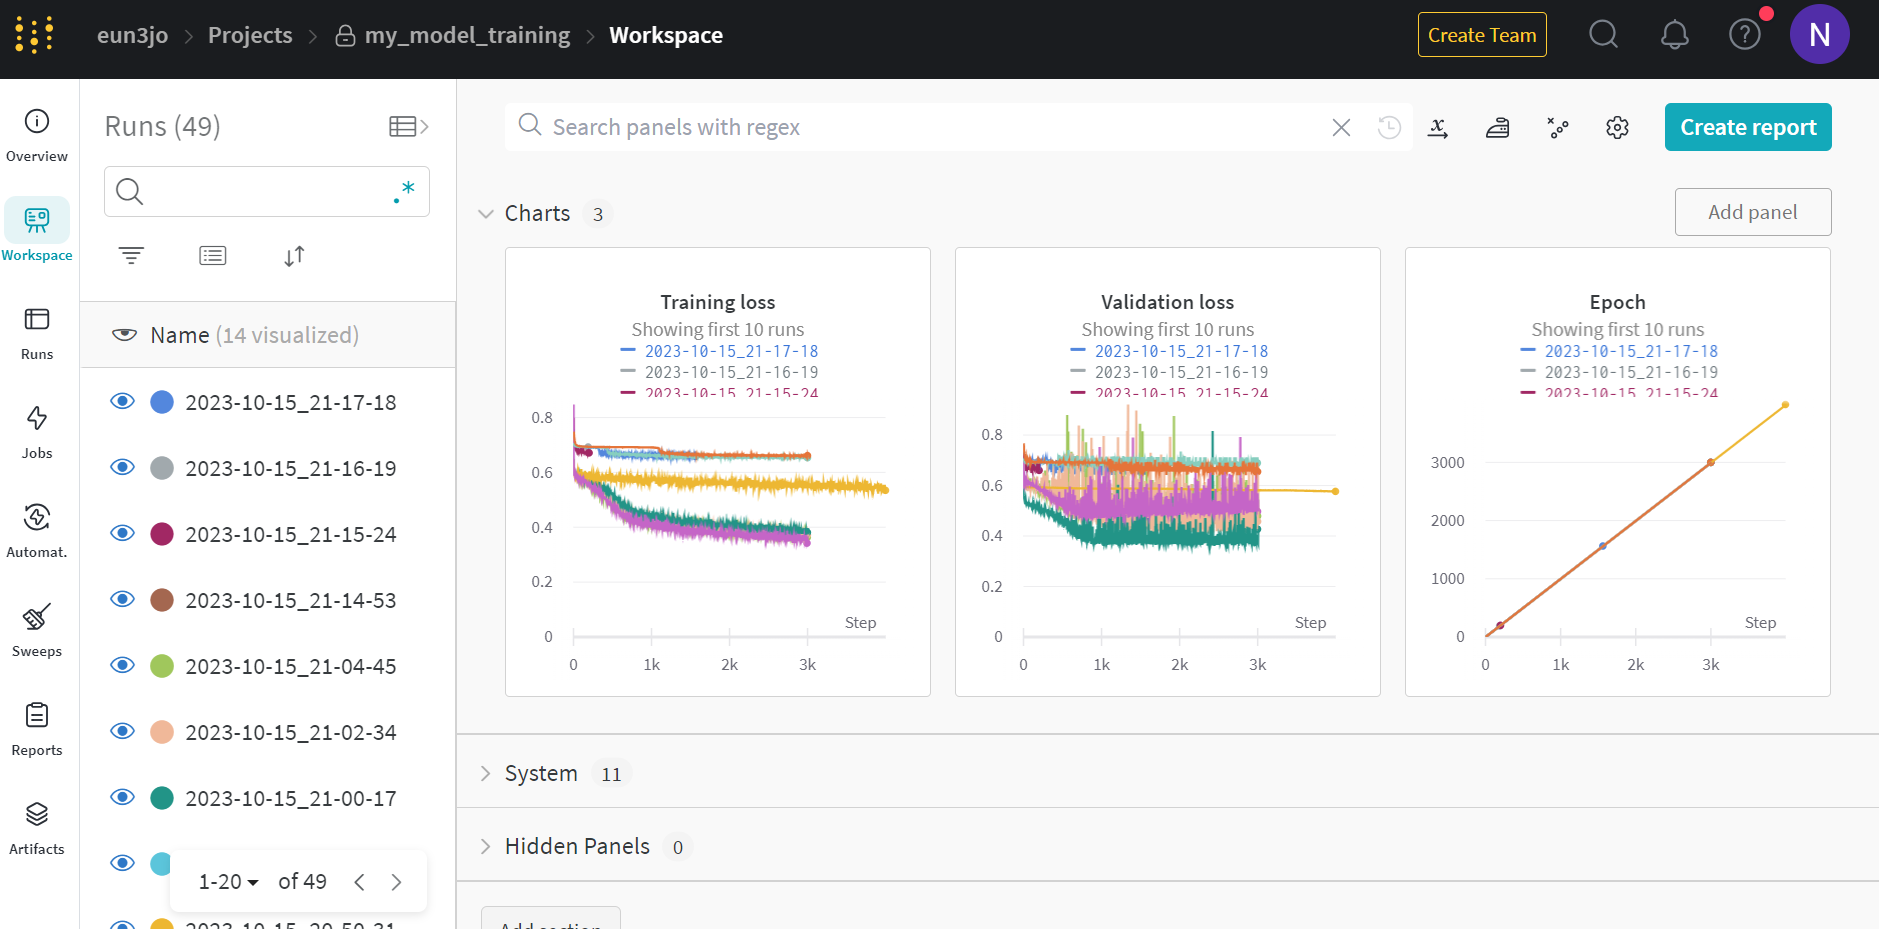

In [27]:
from IPython.display import Image
CURRENT_FILE_PATH = os.path.dirname(os.path.abspath("__file__"))
img = os.path.join(CURRENT_FILE_PATH, "img1.png")
Image(img)

#### [2-3] 더 나은 성능을 산출하는 Activation Function이 있는지 조사하기

![](https://github.com/joeunseam/DeepLearning/blob/main/img2.PNG)

In [ ]:
이미지 링크(이미지 안보일 시 이용) https://github.com/joeunseam/DeepLearning/blob/main/img2.PNG

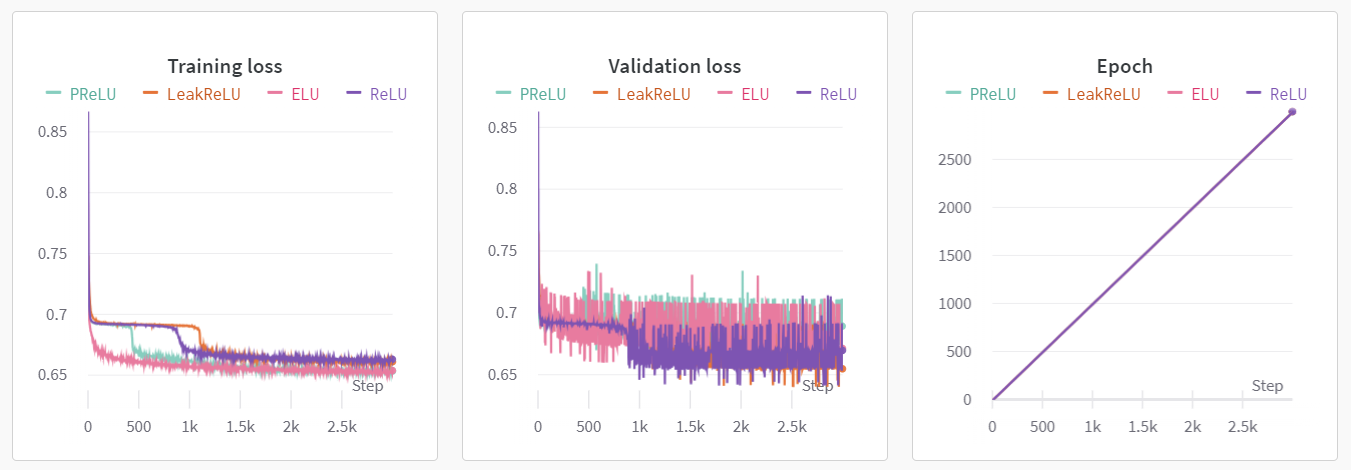

In [28]:
from IPython.display import Image
CURRENT_FILE_PATH = os.path.dirname(os.path.abspath("__file__"))
img = os.path.join(CURRENT_FILE_PATH, "img2.png")
Image(img)

ELU에 대한 그래프가 수렴 속도가 빠르고, 두 로스의 차이가 크지 않으며, 그래프가 부드럽고 안정적인 모양이기 때문에 가장 성능이 좋다고 판단하였다.

## [요구사항 3] 테스트 및 submission.csv 생성

#### [3-1] 좋은 성능을 보이는 Activation	Function으로 모델 구성하기

In [ ]:
# 요구사항 2에 있는 코드
class MyModel(nn.Module):
  def __init__(self, n_input, n_output):
    super().__init__()

    self.model = nn.Sequential(
      nn.Linear(n_input, wandb.config.n_hidden_unit_list[0]),
      nn.ELU(),
      nn.Linear(wandb.config.n_hidden_unit_list[0], wandb.config.n_hidden_unit_list[1]),
      nn.ELU(),
      nn.Linear(wandb.config.n_hidden_unit_list[1], n_output),
    )

  def forward(self, x):
    x = self.model(x)
    return x

ELU()로 모델을 구성하였다.

#### [3-2] 훈련과정 중 어느 Epoch시점에 테스트를 수행하여 submission.csv를 구성해야 하는지 고찰하기 및 파일 생성하기

In [ ]:
# 요구사항 2에 있는 코드
def training_loop(model, optimizer, train_data_loader, validation_data_loader):
  n_epochs = wandb.config.epochs
  loss_fn = nn.BCEWithLogitsLoss()
  next_print_epoch = 100

  best_validation_loss = float('inf') # 추가
  PATIENCE = 300 # 추가
  patience = PATIENCE # 추가

  for epoch in range(1, n_epochs + 1):
    # (생략) 학습 및 검증 데이터 훈련 코드

    wandb.log({
      "Epoch": epoch,
      "Training loss": loss_train / num_trains,
      "Validation loss": loss_validation / num_validations
    })

    # 추가 시작
    current_validation_loss = loss_validation / num_validations
    if current_validation_loss < best_validation_loss:
        best_validation_loss = current_validation_loss
        patience = PATIENCE
    else:
        patience -= 1
        if patience == 0:
            print('Early stopping at epoch {}'.format(epoch))
            break
    # 추가 끝
      
    if epoch >= next_print_epoch:
      print(
        f"Epoch {epoch}, "
        f"Training loss {loss_train / num_trains:.4f}, "
        f"Validation loss {loss_validation / num_validations:.4f}"
      )
      next_print_epoch += 100



In [ ]:
# 요구사항 2에 있는 코드
def main(args):
  # (생략)

  training_loop(
    model=linear_model,
    optimizer=optimizer,
    train_data_loader=train_data_loader,
    validation_data_loader=validation_data_loader
  )

  # 추가 시작
  # submission.csv 파일 생성
  idx, survived = test(test_data_loader)
  data = pd.DataFrame({'PassengerId': idx, 'Survived': survived})
  CURRENT_FILE_PATH = os.path.dirname(os.path.abspath("__file__"))
  data.to_csv(os.path.join(CURRENT_FILE_PATH, "submission.csv"), index=False)
  # 추가 끝
    
  wandb.finish()



training_loop() 함수에 조기 종료 코드를 추가하고, main() 함수에 파일을 생성하는 코드를 추가하였다.  
  
조기 종료는 검증 로스가 연속으로 PATIENCE 번의 에포크 동안 향상되지 않으면 훈련을 조기 종료시키는 방식이다. 
  
모델이 더 이상 성능을 향상시키지 않을 때, 과적합을 방지하고 효율인 훈련에 도움이 된다.

## [요구사항 4] submission.csv 제출 및 등수확인

![](https://github.com/joeunseam/DeepLearning/blob/main/img3.PNG)

In [ ]:
이미지 링크(이미지 안보일 시 이용) https://github.com/joeunseam/DeepLearning/blob/main/img3.PNG

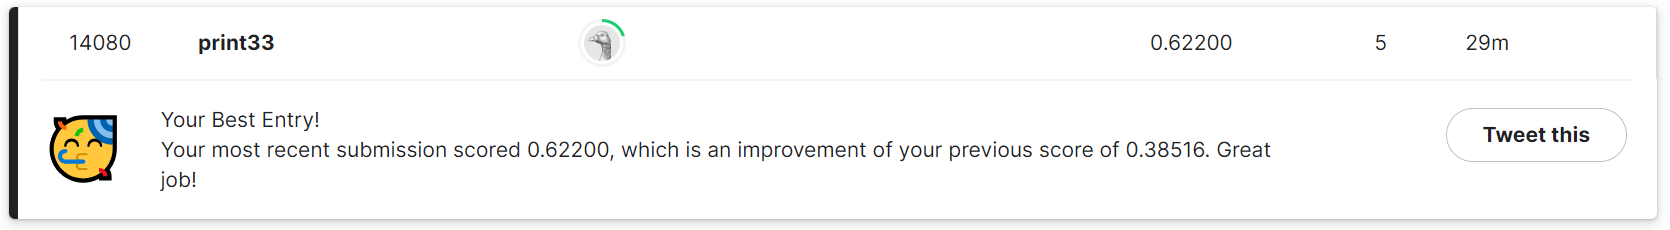

In [26]:
from IPython.display import Image
CURRENT_FILE_PATH = os.path.dirname(os.path.abspath("__file__"))
img = os.path.join(CURRENT_FILE_PATH, "img3.png")
Image(img)

## [요구사항 5] Wandb 페이지 생성 및 URL 제출

##### - x축 Epoch에 대하여, y축에 Training loss 변화 그래프와 Validation loss 변화를 보여주는 그래프 포함하고 있는 Wandb URL

In [ ]:
https://wandb.ai/eun3jo/my_model_training/runs/4stnm4rw?workspace=user-eun3jo

##### - 학습한 그래프 결과가 축적되어 있는 Wandb URL (활성화 함수별 그래프도 포함)

In [ ]:
https://wandb.ai/eun3jo/my_model_training?workspace=user-eun3jo

## [숙제 후기]

training_loop() 함수에서 모델이 학습한 output과 target의 크기가 각각 
(torch.Size([16, 1]), torch.Size([16]))으로 일치하지 않아 손실 함수 사용에 어려움이 있었다.
이 두 크기는 의미상으로는 같지만 차원이 다른 것이기 때문에
.squeeze(1)나 .unsqueeze(1)를 사용하여 한쪽의 차원에 맞춰주면 됐다.
두 경우를 적용하여 실행하였을 때 .squeeze(1)를 사용하여 torch.Size([16]))에 맞추는 것이 더 간단하고 결과가 괜찮아 그렇게 해결하였다.
나중에  다시 두 경우에 대해 정확하게 분석을 해보고, 어떻게 하는 것이 어떤 이점이 있는지 확인해 보는 것이 좋을 것 같다.
  
파이참에서 실행되던 코드가 주피터 노트북에서 에러가 발생하는 어려움도 겪었다. 
두 환경에서 사용하는 문법이 다르거나 wandb 설정을 해주는 방법이 다르다는 원인을 확인할 수 있었다.
  
스코어는 epochs를 늘려 학습을 더 많이 시켜 개선할 수 있었다. 
그리고 찾아보니 남성보다 여성이 더 생존이 많았다고 하는데,
학습 시에 이를 고려하지 않았는데 고려했다면 더 높은 스코어를 얻을 수 있을 것이라 예상된다.
  
이번 과제는 지금까지 배운 파이썬의 문법과 딥러닝 관련 지식, 기능을 직접 활용해 봄으로써
그것들의 쓸모를 직접적으로 느낄 수 있었던 것 같다.
아쉬운 점은 데이터 분석을 먼저 하고, 이를 고려하여 모델을 학습시키는 과정을 하지 못했다는 것이다.
데이터 분석 및 고려가 딥러닝의 큰 부분을 찾이한다는 것을 알 수 있었기 때문이다.
  